In [42]:
# --- DATA PREPARATION ---

import pandas as pd
import os
from glob import glob

print(os.getcwd())

# Path to the data
csv_dir = "data/csv_mapbiomas/"

# Get a list of all CSV files, excluding the 'mapbiomas_description.csv' file
csv_files = sorted(glob(os.path.join(csv_dir, "*_cover_*.csv")))

# Create a list to hold dataframes
dfs = []

# Loop through each file, load it, and add a 'year' column
for file in csv_files:
    # Extract the year from the filename (e.g., 'aulinor_cover_1985.csv')
    try:
        year = int(file.split('_')[-1].split('.')[0])
        df = pd.read_csv(file)
        df['year'] = year
        dfs.append(df)
    except (IndexError, ValueError) as e:
        print(f"Skipping file {os.path.basename(file)} due to format error: {e}")

# Concatenate all dataframes into a single one
df_all = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the combined dataframe to verify
print("Combined DataFrame Head:")
print(df_all.head())

# Display the data types to ensure 'year' is a number
print("\nDataFrame Info:")
df_all.info()

/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/My Drive/Workspace/code/repositories/coastal
Combined DataFrame Head:
   class            nm_mun           descricao  id  area_km2  year
0   33.0     Arroio do Sal  Rio, Lago e Oceano   1   21.6627  1985
1   33.0  Balneário Pinhal  Rio, Lago e Oceano   2   18.4574  1985
2   33.0    Capão da Canoa  Rio, Lago e Oceano   3    3.1010  1985
3   33.0   Capivari do Sul  Rio, Lago e Oceano   4   20.6222  1985
4   33.0             Caraá  Rio, Lago e Oceano   5    0.0399  1985

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   class      2313 non-null   float64
 1   nm_mun     2337 non-null   object 
 2   descricao  2313 non-null   object 
 3   id         2421 non-null   int64  
 4   area_km2   2421 non-null   float64
 5   year       2421 non-null   int64  
dtypes: float64

In [43]:
# --- DATA AGGREGATION ---

# Sum of area for each land use ('descricao') across all municipalities and years
df_summary_landuse = (
    df_all.groupby(['year', 'descricao'])['area_km2']
    .sum()
    .reset_index()
)

# Display the summary table
print("\nLand Use Summary Table:")
print(df_summary_landuse.head())


Land Use Summary Table:
   year                       descricao   area_km2
0  1985                           Arroz   145.1346
1  1985  Campo Alagado e Área Pantanosa   196.1777
2  1985              Formação Campestre   499.0366
3  1985              Formação Florestal  1263.9365
4  1985                 Mosaico de Usos   634.2185


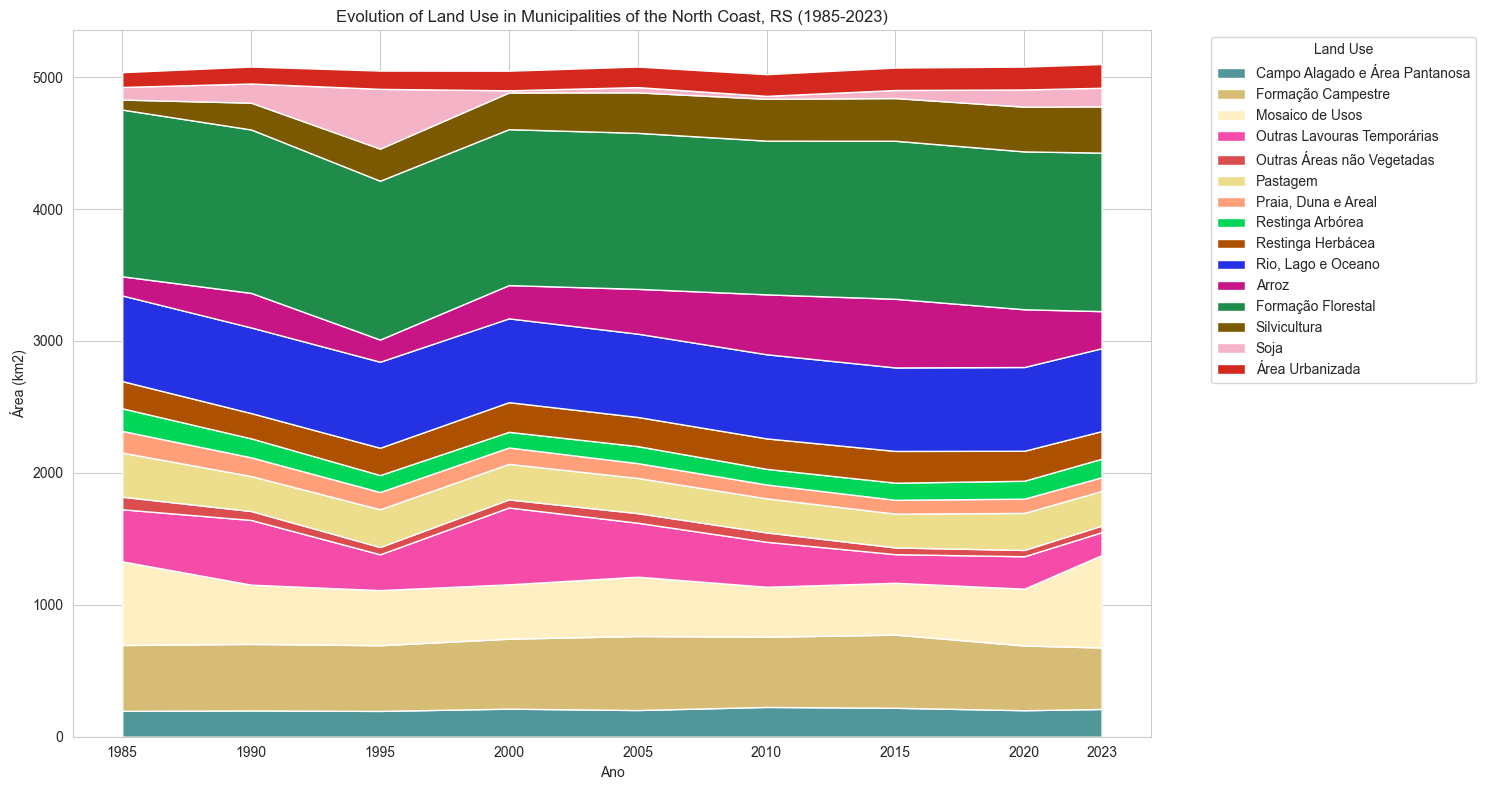

In [44]:
# --- DATA VISUALIZATION 1 (Stacked Area Plot) ---

import matplotlib.pyplot as plt
import seaborn as sns

# Custom color palette
colors_mapbiomas = {
    "Campo Alagado e Área Pantanosa": "#519799",
    "Formação Campestre": "#d6bc74",
    "Mosaico de Usos": "#ffefc3",
    "Outras Lavouras Temporárias": "#f54ca9",
    "Outras Áreas não Vegetadas": "#db4d4f",
    "Pastagem": "#edde8e",
    "Praia, Duna e Areal": "#ffa07a",
    "Restinga Arbórea": "#02d659",
    "Restinga Herbácea": "#ad5100",
    "Rio, Lago e Oceano": "#2532e4",
    "Arroz": "#c71585",
    "Formação Florestal": "#1f8d49",
    "Silvicultura": "#7a5900",
    "Soja": "#f5b3c8",
    "Área Urbanizada": "#d4271e"
}

# --- Prepare data for stackplot ---
# To use stackplot, we need the data in a "wide" format:
# years as index, 'descricao' values as columns, and 'area_km2' as values.
df_pivot = df_summary_landuse.pivot(index='year', columns='descricao', values='area_km2').fillna(0)

# Get the list of 'descricao' in the order of your custom colors
# This ensures consistency in the legend and plot layers
descricao_order = [desc for desc in colors_mapbiomas if desc in df_pivot.columns]
df_pivot = df_pivot[descricao_order] # Reorder columns to match color dictionary

# Get years for the x-axis
years = df_pivot.index

# Get the areas for each 'descricao' as separate arrays for stackplot
areas = [df_pivot[col].values for col in df_pivot.columns]

# Get the colors in the correct order
plot_colors = [colors_mapbiomas[desc] for desc in df_pivot.columns]


# --- Create the Stacked Area Plot ---
sns.set_style("whitegrid")

plt.figure(figsize=(15, 8))

# Create the stacked area plot
plt.stackplot(
    years,
    areas,
    labels=df_pivot.columns, # Labels for the legend
    colors=plot_colors # Use your custom ordered colors
)

# Set the title and labels
plt.title('Evolution of Land Use in Municipalities of the North Coast, RS (1985-2023)')
plt.xlabel('Ano') # Changed to Ano as per your image
plt.ylabel('Área (km2)') # Changed to Área (km2) as per your image
plt.grid(True)

# Place the legend outside the plot
plt.legend(title='Land Use', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust x-axis ticks to show only the available years
plt.xticks(years)
plt.yticks(rotation=0) # Ensure y-axis labels are horizontal

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [46]:
# --- DATA VISUALIZATION 2 (Per-Municipality, Stacked Area Plots) ---

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Custom color palette (re-defined for self-containment)
colors_mapbiomas = {
    "Campo Alagado e Área Pantanosa": "#519799",
    "Formação Campestre": "#d6bc74",
    "Mosaico de Usos": "#ffefc3",
    "Outras Lavouras Temporárias": "#f54ca9",
    "Outras Áreas não Vegetadas": "#db4d4f",
    "Pastagem": "#edde8e",
    "Praia, Duna e Areal": "#ffa07a",
    "Restinga Arbórea": "#02d659",
    "Restinga Herbácea": "#ad5100",
    "Rio, Lago e Oceano": "#2532e4",
    "Arroz": "#c71585",
    "Formação Florestal": "#1f8d49",
    "Silvicultura": "#7a5900",
    "Soja": "#f5b3c8",
    "Área Urbanizada": "#d4271e"
}

# Define the output directory
output_dir = "figures/graphs/tests/"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"Directory '{output_dir}' is ready.")

# Get the list of unique municipalities
municipios = df_all['nm_mun'].unique()

# Loop through each municipality
for mun_name in municipios:
    # Filter data for the current municipality
    df_mun = df_all[df_all['nm_mun'] == mun_name].copy()

    # Sum of area by year and type of coverage for the current municipality
    df_mun_summary = (
        df_mun.groupby(['year', 'descricao'])['area_km2']
        .sum()
        .reset_index()
    )

    # --- ADDED CHECK HERE ---
    # Skip plotting if the municipality has no data
    if df_mun_summary.empty:
        print(f"Skipping {mun_name}: No data found for this municipality.")
        continue # Skip to the next iteration of the loop
    
    # Prepare data for stackplot (pivot the table)
    df_pivot_mun = df_mun_summary.pivot(index='year', columns='descricao', values='area_km2').fillna(0)

    # Reorder columns to match the color dictionary
    descricao_order = [desc for desc in colors_mapbiomas if desc in df_pivot_mun.columns]
    df_pivot_mun = df_pivot_mun[descricao_order]

    # Get years, areas, and colors for plotting
    years = df_pivot_mun.index
    areas = [df_pivot_mun[col].values for col in df_pivot_mun.columns]
    plot_colors = [colors_mapbiomas[desc] for desc in df_pivot_mun.columns]

    # Create the stacked area plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    plt.stackplot(
        years,
        areas,
        labels=df_pivot_mun.columns,
        colors=plot_colors
    )

    # Set title and labels
    plt.title(f'Evolução do Uso da Terra em {mun_name} (1985-2023)')
    plt.xlabel('Ano')
    plt.ylabel('Área (km²)')
    plt.grid(True)
    
    # Place the legend outside the plot
    plt.legend(title='Uso da Terra', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust x-axis ticks
    plt.xticks(years)
    
    plt.tight_layout()

    # Define the filename and save the figure
    file_name = f"land_use_evolution_{mun_name.replace(' ', '_')}.png"
    file_path = os.path.join(output_dir, file_name)
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    
    # Close the plot to free up memory
    plt.close()

    print(f"Generated plot for {mun_name} and saved to '{file_path}'.")

print("\nAll plots have been generated and saved.")

Directory 'figures/graphs/tests/' is ready.
Generated plot for Arroio do Sal and saved to 'figures/graphs/tests/land_use_evolution_Arroio_do_Sal.png'.
Generated plot for Balneário Pinhal and saved to 'figures/graphs/tests/land_use_evolution_Balneário_Pinhal.png'.
Generated plot for Capão da Canoa and saved to 'figures/graphs/tests/land_use_evolution_Capão_da_Canoa.png'.
Generated plot for Capivari do Sul and saved to 'figures/graphs/tests/land_use_evolution_Capivari_do_Sul.png'.
Generated plot for Caraá and saved to 'figures/graphs/tests/land_use_evolution_Caraá.png'.
Generated plot for Cidreira and saved to 'figures/graphs/tests/land_use_evolution_Cidreira.png'.
Generated plot for Dom Pedro de Alcântara and saved to 'figures/graphs/tests/land_use_evolution_Dom_Pedro_de_Alcântara.png'.
Generated plot for Imbé and saved to 'figures/graphs/tests/land_use_evolution_Imbé.png'.
Generated plot for Itati and saved to 'figures/graphs/tests/land_use_evolution_Itati.png'.
Generated plot for Mamp